# CLTV

# Что используем

Pareto/NBD model 



In [5]:
import os 
import sys 
import pandas as pd
import numpy as np 
#import pystan 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime 
from scipy.stats import gaussian_kde
from hashlib import md5
%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


D:\installprogramm\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
transactions = pd.read_csv('data/cdnow_transaction_log.csv')

In [8]:
transactions.head(10)

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34
5,21,1997-01-13,11.77
6,50,1997-01-01,6.79
7,60,1997-02-01,21.75
8,71,1997-01-01,13.97
9,86,1997-01-01,23.94


In [9]:
transactions['date'] = pd.to_datetime(transactions['date'])

<AxesSubplot:xlabel='date', ylabel='Transaction Count'>

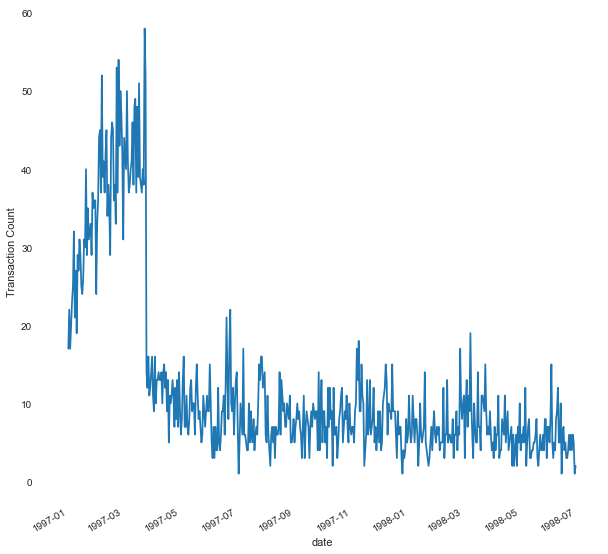

In [10]:
# кол-во транзакций (!!! задать кагортный анализ(ретро) !!! -> чтобы объяснить падение)
ts_transactions = transactions.groupby(['date']).size()
plt.ylabel('Transaction Count') 
ts_transactions.plot()

In [11]:
# посмотрим на смещение во времени, через сколько была следующая покупка

def shift_date(x): 
    x['shifted_date'] = x['date'].shift(-1) 
    return x

transactions_tmp = transactions.sort_values(['date']).\
                                groupby(['cust'], as_index=True).apply(shift_date)    

# сортируем дат: 
transactions_tmp.sort_values(['cust','date'], ascending=True, inplace=True)
transactions_tmp.dropna(inplace=True)

# Вычисляем разницу в днях между покупками: 
transactions_tmp['IPT'] = (transactions_tmp['shifted_date'] - transactions_tmp['date']).apply(lambda x : x.days)

transactions_tmp.head(5) 

,cust,date,sales,shifted_date,IPT
0,4,1997-01-18,29.73,1997-08-02,196
1,4,1997-08-02,14.96,1997-12-12,132
4,21,1997-01-01,63.34,1997-01-13,12
10,111,1997-01-01,35.99,1997-01-11,10
11,111,1997-01-11,32.99,1997-03-15,63


In [12]:
# Считаем среднее
print(transactions_tmp['IPT'].mean())

70.87298294144767


(0.0, 365.0)

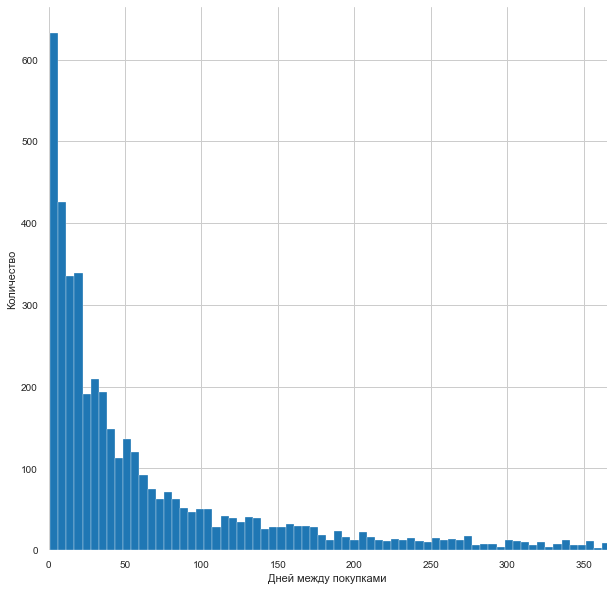

In [13]:
# Смотрим распеределение по параметру дней между покупками

transactions_tmp['IPT'].hist(bins=100)
#plt.yscale('log')
plt.xlabel('Дней между покупками') 
plt.ylabel('Количество') 

plt.xlim([0,365])

1 44


Text(0, 0.5, 'Количество покупателей')

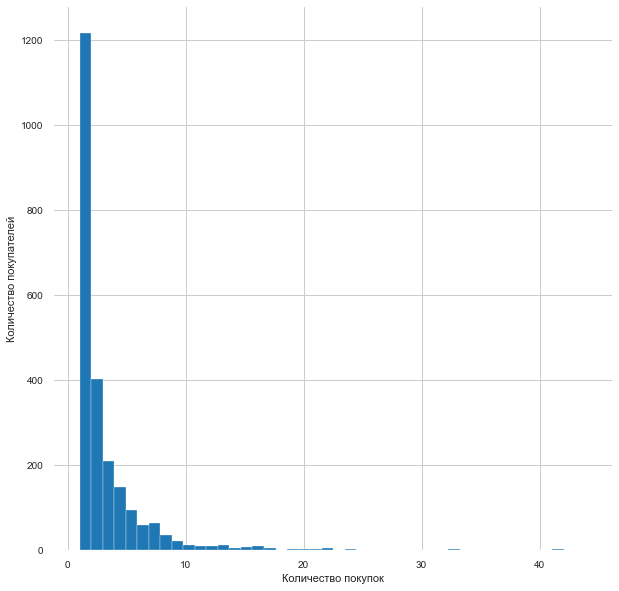

In [14]:
# Распределение покупок между пользователями: 

n_purchases = transactions.groupby(['cust']).size()
print(n_purchases.min(axis=0), n_purchases.max(axis=0))
n_purchases.hist(bins=(n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1)
plt.xlabel('Количество покупок') 
plt.ylabel('Количество покупателей') 

### Вывод

Больше 50% прокупателей делают 1 покупку в 1 - 1.5 года

--------------------

# RFM

* Recency : время между первой и последней покупкой
* Frequency : частота дейтвией (кол-во покупок - 1)
* monetary value : среднее кол-во по плажам на дату 
* T : время между последней покупкой и текущей датой

In [15]:
# Фиксируем период для колибровки
# Зафиксируем дату и сделаем отбор на 6 месяцев

end_calibration = pd.to_datetime('1997-12-31')
train = transactions[transactions.date <= end_calibration]
holdout = transactions[transactions.date > end_calibration]

## Делаем разбивку по группам (бинам)

In [16]:
# Вычисляем М параметр на покупателя и дату

train2 = train.sort_values(['date'], ascending=True)\
              .groupby(['cust', 'date'], 
                        as_index=False)['sales'].sum()


train2.head(5)

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


In [17]:
# 1 функция на весь RFM

def compute_rfm(x, end_calibration): 
    x['recency'] = (x['date'].max() - x['date'].min()).days
    x['frequency'] = x['date'].count()-1
    x['T'] = (end_calibration - x['date'].min()).days
    x['monetary_value'] = x['sales'].mean()
    return x

In [18]:
train3 = train2.groupby(['cust']).apply(lambda x: compute_rfm(x, end_calibration))

train3.head(5)

,cust,date,sales,recency,frequency,T,monetary_value
0,4,1997-01-18,29.73,328,2,347,23.723333
1,4,1997-08-02,14.96,328,2,347,23.723333
2,4,1997-12-12,26.48,328,2,347,23.723333
3,18,1997-01-04,14.96,0,0,361,14.960000
4,21,1997-01-01,63.34,12,1,364,37.555000


In [19]:
# отбираем 1 строку, которая показывает агрегированные данные пользователя
rfm = train3[['cust', 'recency', 'frequency', 'T', 'monetary_value']].groupby(['cust']).first()

rfm.head(5)

,recency,frequency,T,monetary_value
cust,,,,
4,328,2,347,23.723333
18,0,0,361,14.960000
21,12,1,364,37.555000
50,0,0,364,6.790000
60,0,0,333,21.750000


In [20]:
rfm.describe()

,recency,frequency,T,monetary_value
count,2357.000000,2357.000000,2357.000000,2357.000000
mean,75.550276,1.352143,321.003818,32.836897
std,110.231161,2.792310,23.277967,31.103740
min,0.000000,0.000000,281.000000,0.000000
25%,0.000000,0.000000,301.000000,14.990000
50%,0.000000,0.000000,321.000000,24.883333
75%,150.000000,2.000000,340.000000,39.245000
max,362.000000,37.000000,364.000000,506.970000


# Train Pareto/NBD Model. 

Указать в модели:

* дата - время 
* параметры для модели (как в обычных sckitlearn)
* описание процесса обучения модели

Расчет на основе правдоподобия (likelihood) Pareto/NBD model, расчитывается по формуле (в библиотеке pyStan): 
$$ L(\lambda, \mu | x, t_x, T) = \frac{\lambda^x \mu}{\lambda+\mu}e^{-(\lambda+\mu)t_x}+\frac{\lambda^{x+1}}{\lambda+\mu}e^{-(\lambda+\mu)T} $$

Параметры: $\lambda$ количество уровней (бинов) в распределение (Пуассона), $\mu$ наклон в распеределении, $\sim 1/\mu$. - типичный расчет "существования" пользователя 

Расчет Гамма распределения на основе $\lambda$ и $\mu$ : 
$$g(\lambda|r,\alpha) = \frac{\alpha^r}{\Gamma(r)}\lambda^{r-1}e^{-\lambda \alpha} $$

$$g(\mu|s,\beta) = \frac{\beta^s}{\Gamma(s)}\mu^{s-1}e^{-\mu \beta} \; . $$ 

Для каждого из 4х параметров $(r,\alpha,s,\beta)$, можно расчитать гипер параметры

D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


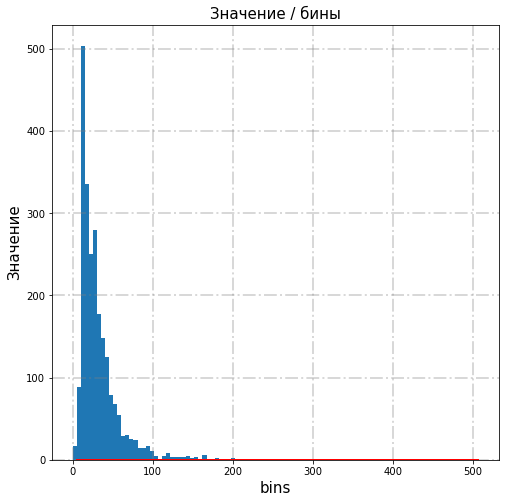

In [40]:
# Очень простой способ

x_m, alpha = 1, rfm['monetary_value'].max() / 100


samples = rfm['monetary_value'].tolist() * x_m
count, bins, _ = plt.hist(samples, 100)

fit = alpha*x_m**alpha / bins**(alpha+1)
plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
plt.xlabel('bins', fontsize=15)
plt.ylabel('Значение', fontsize=15)
plt.title('Значение / бины', fontsize=15)
plt.grid(b=True, color='grey', alpha=0.3, linestyle='-.', linewidth=2)
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

In [0]:
# Учим STAN на 1000 итерациях (для теста можно 100)

paretonbd_model="""
data{
int<lower=0> n_cust; //кол-во покупателей 
vector<lower=0>[n_cust] x; 
vector<lower=0>[n_cust] tx; 
vector<lower=0>[n_cust] T; 
}

parameters{
// параметр от 0 до 1 (лямда и мю)
vector <lower=0,upper=1.0>[n_cust] lambda; 
vector <lower=0,upper=1.0>[n_cust] mu;


real <lower=0>r;
real <lower=0>alpha;
real <lower=0>s;
real <lower=0>beta;
}

model{

// переменные правдоподобия: 
vector[n_cust] like1; // likelihood
vector[n_cust] like2; // likelihood 

// гиперпараметры r, alpha, s, beta. 
r ~ normal(0.5,0.1);
alpha ~ normal(10,1);
s ~ normal(0.5,0.1);
beta ~ normal(10,1);

// установка распределений
lambda ~ gamma(r,alpha); 
mu ~ gamma(s,beta);

// Расчет правдоподобия для Pareto/NBD model : 
like1 = x .* log(lambda) + log(mu) - log(mu+lambda) - tx .* (mu+lambda);
like2 = (x + 1) .* log(lambda) - log(mu+lambda) - T .* (lambda+mu);

// расчет таргита для модели
target+= log(exp(like1)+exp(like2));
}
"""

# инициализация модели : 
data={'n_cust':len(rfm),
    'x':rfm['frequency'].values,
    'tx':rfm['recency'].values,
    'T':rfm['T'].values
}

In [0]:
# Пишем кэширование для модели

# https://pystan.readthedocs.io/en/latest/avoiding_recompilation.html
def stan_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm.sampling(**kwargs)

iterations = 1000 #100
warmup = 500  # 5

# Запускаем 
pareto_nbd_fit = stan_cache(paretonbd_model, model_name='paretonbd_model', \
                                  data=data, chains=1, iter=iterations, warmup=warmup)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76111598b747c5ab299e594dcfa74504 NOW.


In [0]:
# извлекаем параметры из обученной модели

trace = pareto_nbd_fit.extract()
lambdas = trace['lambda']
mus = trace['mu']

# Predict

Мы можем получить параметры, как результат обучения $(r,\alpha,s,\beta)$

Некоторые параметры $\lambda,\mu$ , могу явяляться параметрами для каждого пользователя. 

С помощью $(\lambda,\mu)$ параметром расчет становиться проще для каждого пользователя в момент времени $(0,t]$ , по формуле : 
$$ E[X(t)~|~\lambda, \mu] = \frac{\lambda}{\mu}-\frac{\lambda}{\mu}e^{-\mu t } $$

Где X(t) - количество покупок между 0 и $t$. 


## Observations vs Predictions 

In [0]:
# Возьмем ожидаемый результат, как среднее от [X(t) | lambda, mu] 

dt_train = 365.0 # это количество дней 
training_predictions = (lambdas/mus-lambdas/mus*np.exp(-mus*dt_train)).mean(axis=0)
rfm['model_train_count'] = training_predictions 

In [0]:
# используем метрику RMSE
rmse_train_count = (rfm['model_train_count'] - rfm['frequency']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(rfm))
print('RMSE =', rmse_train_count)

In [0]:
def plot_scatter(dataframe, 
                 colx, 
                 coly, 
                 xlabel='Observed Counts', 
                 ylabel='Predicted Counts', 
                 xlim=[0,15], ylim=[0,15], density=True): 
    """
    Функция рисования 
    
    Args : 
        - dataframe (dataframe) : pandas dataframe 
        - colx (str) : колонка для X оси
        - coly (str) : колонка для Y оси
        - xlabel (str) : имена по X
        - ylabel (str) : имена по Y
        - xlim (list) : количество групп по X
        - ylim (list) количество групп по Y 
        - density (bool) : обозначение линии 
        
    """

    if not density : 
        plt.scatter(dataframe[colx].values, dataframe[coly].values)
    else:
        xvals = dataframe[colx].values
        yvals = dataframe[coly].values
        xy = np.vstack([xvals, yvals])
        z = gaussian_kde(xy)(xy)
        plt.scatter(xvals, yvals, c=z, s=10, edgecolor='')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.linspace(xlim[0], xlim[1], 100), 
             np.linspace(ylim[0], ylim[1], 100), 
             color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot()

In [0]:
# Визуализация
plot_scatter(rfm, 'frequency', 'model_train_count')

# Сравнение теста и трейна


Будем считать, что $Y$ это количество покупок в период $dt$ , где $dt$ отвечает за интервал дней $(T, T+dt]$. Тогда условие $Y(dt)$ будет фактом, что покупатель ещё "живой для магазин" $T$. Тогда буде формула:  

$$ E[Y(dt)~|~\lambda, \mu, x, t_x, T] = E[Y(dt) | \lambda, \mu, \rm{alive~at} T ] \times P(\tau > T | \lambda, \mu x, t_x, T)$$

Вероятность "жизни" пользователя указана в параметре $\tau$ проецируемый на период $T$. То есть, пользователь "живой" во время $T$.  Общая формула расчета: 

$$P(\tau > T|\lambda, \mu, x, t_x, T) = \frac{1}{1+\mu/(\mu+\lambda)[e^{(\lambda + \mu)(T-t_x)}-1]} \; .$$


Выражение $E[Y(dt) | \lambda, \mu, \rm{alive~at~}T ]$ отвечает за расчет полной жизни и дохода от пользователя: 

$$ E[Y(dt) | \lambda, \mu, \rm{alive~at~}T ] = \frac{\lambda}{\mu}-\frac{\lambda}{\mu}e^{-\mu dt } \; .$$




In [0]:
def prob_alive_at_T(lam, mu, t_x, T): 
    """Расчет вероятности T от lambda, mu, t_x, T"""
    return 1 / ( 1 + mu / (mu + lam) * (np.exp((lam + mu) * (T - t_x)) - 1) )

In [0]:
# Предикт на 6 месяцев
dt_hold = 180.0

# извлекаем параметры
tmp = rfm['T'].values 
T_values = np.tile(tmp, [iterations - warmup, 1])
tmp2 = rfm['recency'].values 
recency_values = np.tile(tmp2, [iterations - warmup, 1])

# предикт
holdout_predictions = ((lambdas/mus - lambdas/mus*np.exp(-mus*dt_hold)) * \
                                prob_alive_at_T(lambdas, mus, recency_values, T_values)).mean(axis=0)

rfm['model_holdout_count'] = np.asarray(holdout_predictions) 

In [0]:
# кол-во покупателей на дату: 
holdout_counts = holdout.groupby(['cust', 'date'], as_index=False).size().reset_index()

# кол-во покупателей: 
holdout_counts = holdout_counts.groupby(['cust']).size()

# соединим с RFM объектами
rfm_with_holdout = rfm.merge(pd.DataFrame(holdout_counts), how='left', left_index=True, right_index=True)
rfm_with_holdout.rename(columns={0:'obs_holdout_count'}, inplace=True)
rfm_with_holdout.fillna(0, inplace=True)

In [0]:
# визуализация: 

rmse_holdout_count=(rfm_with_holdout['model_holdout_count'] - rfm_with_holdout['obs_holdout_count']).apply(lambda x :x*x)
rmse_holdout_count=np.sqrt(rmse_holdout_count.sum()/len(rfm_with_holdout))
print('RMSE =', rmse_holdout_count)
plot_scatter(rfm_with_holdout, 'obs_holdout_count', 'model_holdout_count')

# CLV 


CLV  расчитывается по формуле
$$CLV(t,t+dt) = E(M)~\times~ E[Y(dt)~|~\lambda, \mu, x, t_x, T] $$

In [0]:
rfm['model_holdout_clv'] = rfm_with_holdout['model_holdout_count'] * rfm['E_M']
rfm['obs_holdout_clv'] = rfm_with_holdout['obs_holdout_count'] * #среднее значение в группе RFM
rmse_holdout_clv = (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])* \
                   (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])
rmse_holdout_clv = np.sqrt(rmse_holdout_clv.sum()/len(rfm))

In [0]:
# Покажем график
print('RMSE =', rmse_holdout_clv)
plot_scatter(rfm, 'obs_holdout_clv', 'model_holdout_clv',
             xlabel='Observed Value in the Holdout Period',
             ylabel='Modeled Value in the Holdout Period', 
             xlim=[0,300.0],ylim=[0,300.0])